In [1]:
import os
import sys

# adding classes folder to system path
sys.path.insert(0, os.path.abspath('..') + '/gispy')

import re
import copy
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gist import GIS
from wolfe import WolfeData, wolfe_eval

def plot_scores(df_gist, df_no_gist, gispy_cols_head=False, output_file_name='scores.pdf'):
    # formula = PCREFz + PCDCz + (zSMCAUSlsa - zSMCAUSwn) - PCCNCz - zWRDIMGc - zWRDHYPnv
    cols = [["PCREFz", 0, 0], ["PCDCz", 0, 1], ["zSMCAUSlsa", 0, 2], ["zSMCAUSwn", 1, 0], ["PCCNCz", 1, 1], ["zWRDIMGc", 1, 2], ["zWRDHYPnv", 2, 0]]

    gispy_cols = [["PCREF", 0, 0], ["PCDC", 0, 1], ["SMCAUSlsa", 0, 2], ["SMCAUSwn", 1, 0], ["PCCNC", 1, 1], ["WRDIMGc", 1, 2], ["WRDHYPnv", 2, 0]]

    fig, axis = plt.subplots(3, 3, figsize=(7,7), constrained_layout=True)

    if gispy_cols_head:
        cols = gispy_cols
    
    for col in cols:
        axis[col[1], col[2]].boxplot([df_gist[col[0]], df_no_gist[col[0]]], labels=['Gist', 'No Gist'])
        axis[col[1], col[2]].set_title(col[0])

    axis[2, 1].set_axis_off()
    axis[2, 2].set_axis_off()
    
    fig.savefig(output_file_name)

## Report vs. Opinion

In [2]:
folder_path = '../data/wolfe/Report_vs_Opinion/Report_Opinion.docx'
df = WolfeData().convert_opinion_report_data(folder_path, create_text_file=False)
print(len(df))

50


In [3]:
index_flag = {'PCREFz': True,
              'PCDCz': True,
              'PCCNCz': True,
              'zSMCAUSlsa': True,
              'zSMCAUSwn': True,
              'zWRDIMGc': True,
              'zWRDHYPnv': True}

results, df_yes, df_no = wolfe_eval('../data/wolfe_cohmetrix.csv', 
                                    'opinion', 
                                    'report', 
                                    index_flag,
                                    use_wolfe_vars=False, 
                                    use_gispy_vars=False)

In [4]:
results

{'mean_gist_yes': -0.810821447390109,
 'mean_gist_no': -3.505483055275745,
 'ttest_statistic': 3.92108117863536,
 'ttest_pvalue': 0.00027956041206192667}

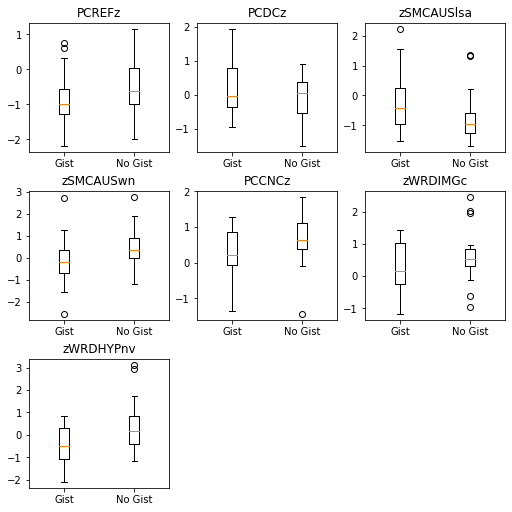

In [5]:
plot_scores(df_yes, df_no, gispy_cols_head=False)

## Methods vs. Discussion

In [6]:
folder_path = '../data/wolfe/Methods_vs_Discussion/Methods_Discussion.docx'
df = WolfeData().convert_methods_discussion_data(folder_path, create_text_file=False)
print(len(df))

25


In [15]:
results, df_yes, df_no = wolfe_eval('../data/wolfe_gispy.csv', 
                                    gist_prefix='d', 
                                    no_gist_prefix='m', 
                                    use_wolfe_vars=False, 
                                    use_gispy_vars=True)

In [16]:
results

{'mean_gist_yes': 2.7935938527941517,
 'mean_gist_no': -0.8010501001405407,
 'ttest_statistic': 4.867443394863603,
 'ttest_pvalue': 1.2642598061661247e-05}

In [19]:
float(results['ttest_pvalue'])
round(x, 10)
"{:.10f}".format(x)

'0.0000000852'

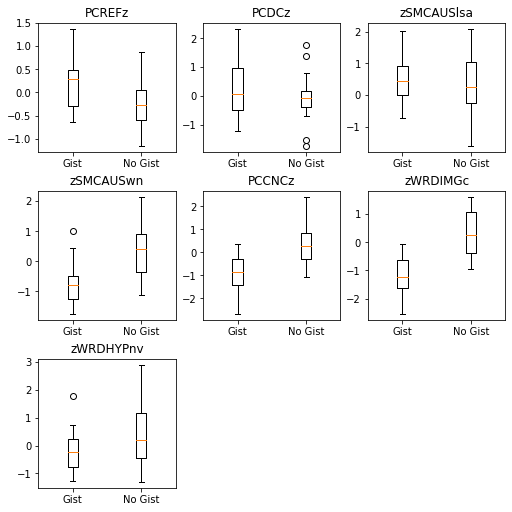

In [13]:
plot_scores(df_yes, df_no, gispy_cols_head=False)

## NCI Coh-Metrix Scored
There are two types of text for each disease: 1) `Patient` version, and 2) `Health Professional (HP)` version. And for each type, there are different texts separately annotated for gist and verbatim (T1, T2, T3, etc.) Based on Chris Wolfe: "the articles for Physicians (HP, I guess) tended to be more gist whereas the ones for patients tended to be more verbatim"

For now, since there are no detailed scores available for different texts, we don’t use the NCI-related texts for evaluating our tool.


In [9]:
file_paths = ['../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Mitch.docx',
              '../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Tatum.docx',
              '../data/wolfe/NCI_CohMetrix_Scored_042918/NCI_Texts-Vasanthi.docx']

In [10]:
df = pd.DataFrame(columns=['title', 'url', 'text'])

for file_path in file_paths:
    lines = read_word_text(file_path).split('\n')
    i = 4
    title = lines[0]
    url = lines[2]
    current_text = []
    while i < len(lines):
        if lines[i].startswith('https'):
            # saving the current article
            df = df.append({'title': title, 'url': url, 'text': '\n'.join(current_text)}, ignore_index=True)
            title = lines[i-2]
            url = lines[i]
            current_text = []
            i += 1
        else:
            current_text.append(lines[i])
            i += 1

In [11]:
df.head(3)

,title,url,text
0,Leukemia/Patient Version,https://www.cancer.gov/types/leukemia,OVERVIEW\n\nLeukemia is cancer of the blood ce...
1,Leukemia/HP Version,https://www.cancer.gov/types/leukemia/hp,\nT1\n\nGeneral Information About Adult Acute ...
2,Adrenocortical Carcinoma/Patient Version,https://www.cancer.gov/types/adrenocortical,\nOVERVIEW\n\nAdrenocortical cancer is a rare ...


In [12]:
df.to_excel('nci_cohmetrix_scored.xlsx')